In [1]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install tensorflow

In [2]:
import tensorflow as tf
import keras
from tensorflow.keras import datasets, layers, models  
import numpy as np  
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from PIL import Image
from skimage.transform import resize

# Load LIDC dataset
### Step 1: Load all nodules as a 3D representation in numpy array & the labels from the nodule name

In [15]:
lidc_path = Path('F:\\master\\manifest-1600709154662\\nodules_16slices')
images = []
labels = []
nodules_path = list(lidc_path.iterdir())
for nodule_path in nodules_path:
    images_path = list(nodule_path.iterdir())
    # Merge all slices of a nodule together --> create 3D representation of the nodule
    image_nodule = []
    for image_path in images_path:
        # Load slice image
        image_slice = np.array(Image.open(image_path)) / 255.0
        # Add it to the nodule
        image_nodule.append(image_slice)
    # convert the 3D nodule to numpy array
    image_nodule = np.array(image_nodule)
    
    if image_nodule.shape  == (16, 64, 64):
        # Add the nodule 3D representation to the list of images
        images.append(image_nodule)
        # Save nodule label (diagnostic)
        labels.append(int(nodule_path.name.split('_')[5]))
    else:
        print(f'[ERROR] {nodule_path.name} has shape {image_nodule.shape}, but expected shape is: (16, 64, 64)')
# convert the dataset to numpy array
images = np.array(images)

[ERROR] patient_462_nod_1_diag_2 has shape (16, 64, 54), but expected shape is: (16, 64, 64)
[ERROR] patient_463_nod_1_diag_2 has shape (16, 64, 54), but expected shape is: (16, 64, 64)
[ERROR] patient_655_nod_3_diag_2 has shape (16, 64, 57), but expected shape is: (16, 64, 64)
[ERROR] patient_997_nod_2_diag_1 has shape (16, 64, 55), but expected shape is: (16, 64, 64)


In [11]:
images_unqique_shape = set([str(image.shape) for image in images])
for shape in images_unqique_shape:
    print(f'{shape} --> {images_shape.count(shape)}')

(16, 64, 54) --> 2
(16, 64, 55) --> 1
(16, 64, 57) --> 1
(16, 64, 64) --> 3170


In [14]:
images[0].shape

(16, 64, 64)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a figure and a 3D axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Create meshgrid for the volume
x, y, z = np.meshgrid(np.arange(images[0].shape[0]),
                      np.arange(images[0].shape[1]),
                      np.arange(images[0].shape[2]), indexing='ij')

# Plot volume rendering
ax.scatter(x.flatten(), y.flatten(), z.flatten(), c=images[0].flatten(), cmap='gray', marker='o')

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Reconstruction')

# Show plot
plt.show()

#### Visualize data

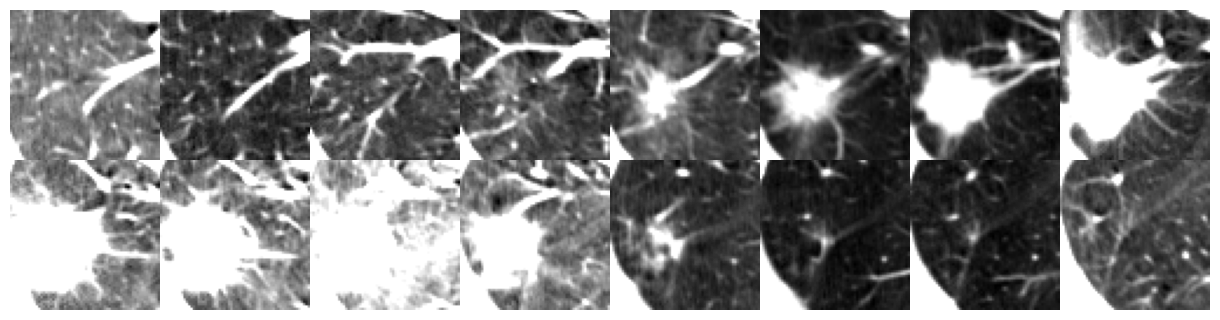

In [78]:
def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of X CT slices"""
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i, j], cmap="gray")  # Corrected indexing
            #axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()


# Visualize montage of slices.
plot_slices(
    num_rows=2, 
    num_columns=8, 
    width=64, 
    height=64, 
    data=images[0].transpose()
)

### Ste 2: Simplify labels
The label is a subjective assessment of the likelihood of malignancy of the given nodule, assuming the scan originated from a 60-year-old male smoker.

The original label system has 5 labels:

1: ‘Highly Unlikely’

2: ‘Moderately Unlikely’

3: ‘Indeterminate’

4: ‘Moderately Suspicious’

5: ‘Highly Suspicious’

It has been simplified to a binary clasification system, being:

0: if original label < 3 (benign)

1: if original label > 3 (malign)

In [16]:
# Simplify label system
labels = [0 if label<3 else 1 if label>3  for label in labels]
labels = np.array(labels)

Divide between train and test data

In [17]:
# Create train and test dataset
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.33, random_state=42)

# Building the CNN:
Models used by others: https://github.com/marichka-dobko/Lung_Nodule_Classification/blob/master/src_keras/models_keras.py

A simple CNN with 5 convolutional layers

In [62]:
def le_net_3d():
    model = keras.Sequential()
    model.add(layers.Convolution3D(6, kernel_size=(5, 5, 5), activation='relu', input_shape=(16,64,64,1)))
    model.add(layers.MaxPooling3D(strides=2)) 
    model.add(layers.Convolution3D(16, kernel_size=(5, 5, 5), activation='relu'))
    model.add(layers.MaxPooling3D(strides=2)) 

    model.add(layers.Flatten())
    model.add(layers.Dense(120, activation='relu'))
    model.add(layers.Dense(84, activation='relu'))
    model.add(layers.Dense(2, activation='softmax'))

    return model


# Build model.
model = le_net_3d()
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_42 (Conv3D)          (None, 12, 60, 60, 6)     756       
                                                                 
 max_pooling3d_38 (MaxPooli  (None, 6, 30, 30, 6)      0         
 ng3D)                                                           
                                                                 
 conv3d_43 (Conv3D)          (None, 2, 26, 26, 16)     12016     
                                                                 
 max_pooling3d_39 (MaxPooli  (None, 1, 13, 13, 16)     0         
 ng3D)                                                           
                                                                 
 flatten_11 (Flatten)        (None, 2704)              0         
                                                                 
 dense_47 (Dense)            (None, 120)             

We can then compile and train our model. We obtain a validation accuracy of over 99% after just 5 epochs.

In [63]:
def fit_model(model, epochs):  
    model.compile(  
        optimizer="adam",  
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),  
        metrics=["accuracy"],  
    )  

    model.fit(  
        train_images,  
        train_labels,  
        epochs=epochs,  
        validation_data=(test_images, test_labels),  
    )  
    return model  


model = fit_model(model, epochs=50)

Epoch 1/50


C:\Users\pau_a\anaconda3\Lib\site-packages\keras\src\backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


67/67 [==============================] - 15s 209ms/step - loss: 0.6899 - accuracy: 0.5511 - val_loss: 0.6940 - val_accuracy: 0.4728
Epoch 2/50
67/67 [==============================] - 10s 142ms/step - loss: 0.6853 - accuracy: 0.5525 - val_loss: 0.6741 - val_accuracy: 0.6141
Epoch 3/50
67/67 [==============================] - 10s 151ms/step - loss: 0.6801 - accuracy: 0.5761 - val_loss: 0.6617 - val_accuracy: 0.6170
Epoch 4/50
67/67 [==============================] - 11s 165ms/step - loss: 0.6707 - accuracy: 0.5869 - val_loss: 0.6619 - val_accuracy: 0.6246
Epoch 5/50
67/67 [==============================] - 11s 167ms/step - loss: 0.6739 - accuracy: 0.5789 - val_loss: 0.6602 - val_accuracy: 0.6266
Epoch 6/50
67/67 [==============================] - 12s 183ms/step - loss: 0.6640 - accuracy: 0.5992 - val_loss: 0.6363 - val_accuracy: 0.6457
Epoch 7/50
67/67 [==============================] - 12s 181ms/step - loss: 0.6374 - accuracy: 0.6472 - val_loss: 0.6316 - val_accuracy: 0.6638
Epoch 8/50

Now, let’s see how this model handles out-of-distribution data. Imagine we deploy this model to recognize digits, but users sometimes fail to write down the entire digit. What happens when users do not write down the entire digit? We can get an answer to this question by gradually removing more and more information from a digit, and seeing how our model handles the perturbed inputs. We can define our function to remove signal as follows:

In [130]:
def remove_signal(img: np.ndarray, slice_index: int) -> np.ndarray:  
    img = img.copy()  
    img[slice_index, :, :] = 0  # Set the specified slice to black
    img[-slice_index, :, :] = 0  # Set the specified slice to black
    return img

And then we perturb our images:

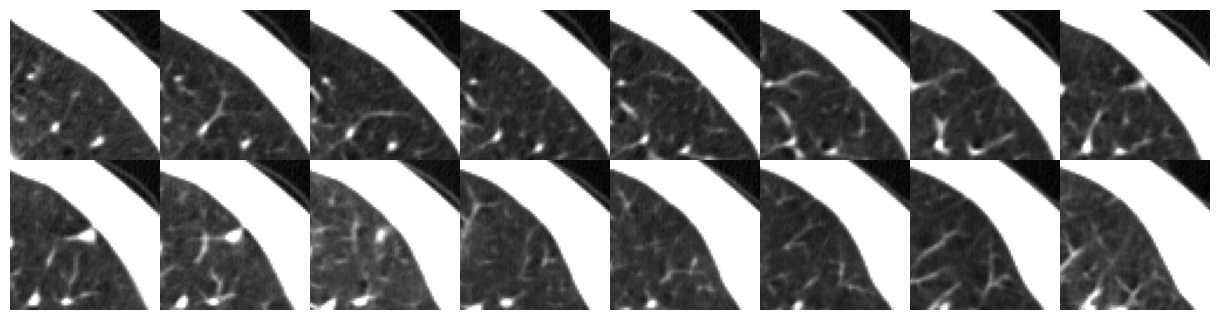

In [131]:
img = test_images[0]
img_label = test_labels[0]
# Visualize montage of slices.
plot_slices(
    num_rows=2, 
    num_columns=8, 
    width=64, 
    height=64, 
    data=img.transpose()
)

In [132]:
imgs = []
img_perturbed = img
for i in range(0, 16):  
   img_perturbed = remove_signal(img_perturbed, i)  
   if np.array_equal(img, img_perturbed):  
     continue  
   imgs.append(img_perturbed)  
   if img_perturbed.sum() == 0:  
     break

We only add perturbed images to our list of images if setting a row to 0 actually changes the original image ( if np.array_equal(img, img_perturbed)) and stop once the image is completely black, meaning it just contains pixels with a value of 0. We run inference on these images:

In [133]:
softmax_predictions = tf.nn.softmax(model(np.expand_dims(imgs, -1)), axis=1)

We can then plot all images with their predicted labels and confidence scores:

Ground truth: 0
1 - 73.10%


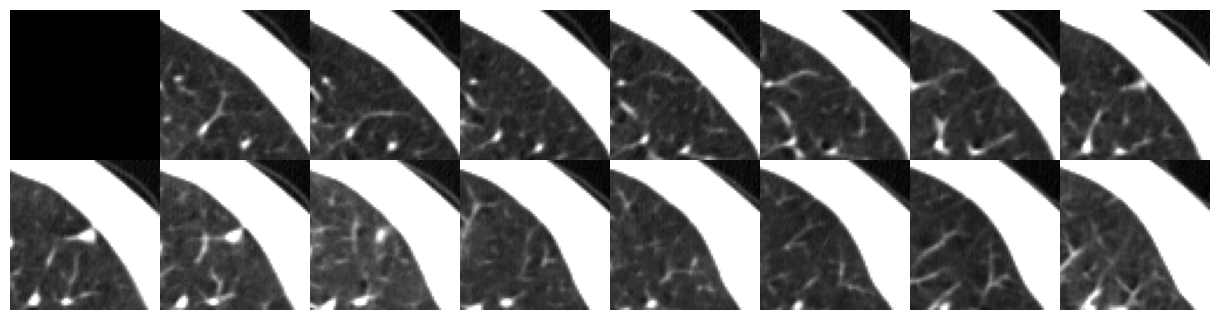

1 - 73.08%


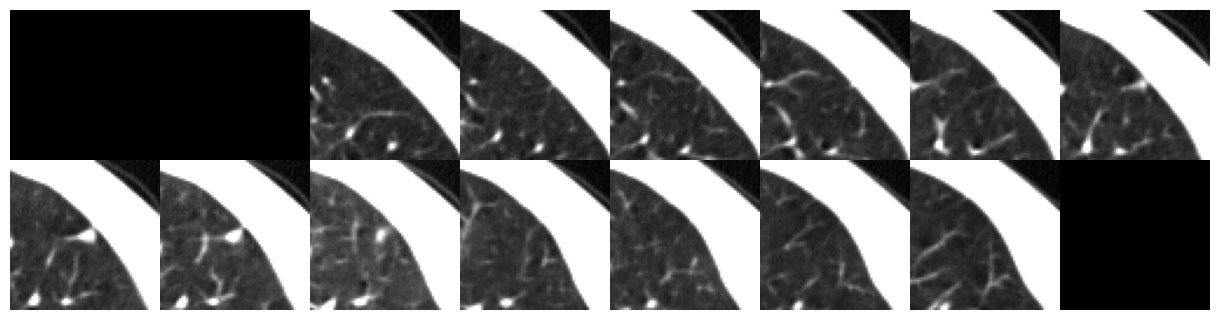

0 - 72.66%


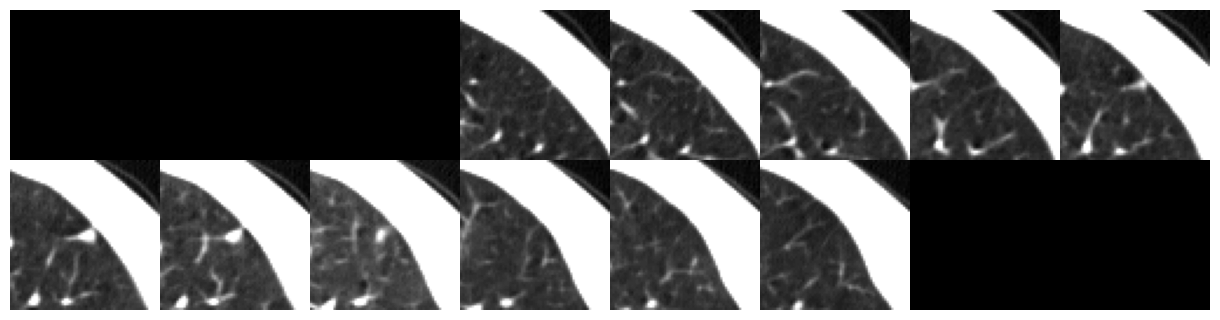

0 - 72.85%


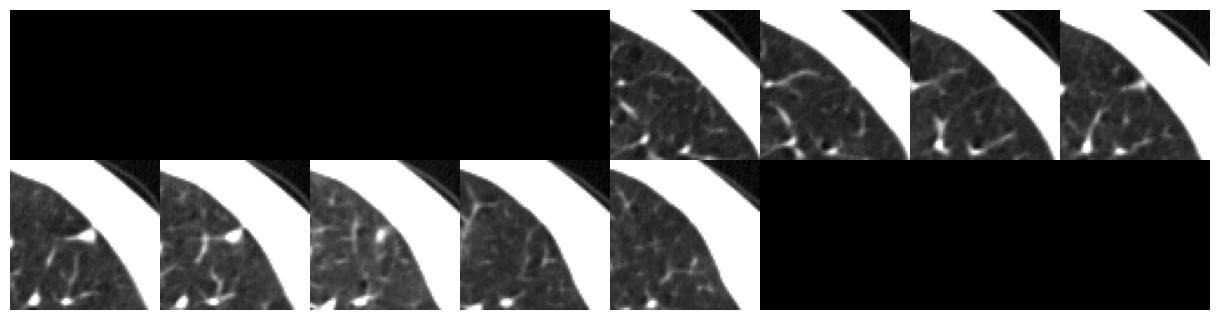

0 - 73.10%


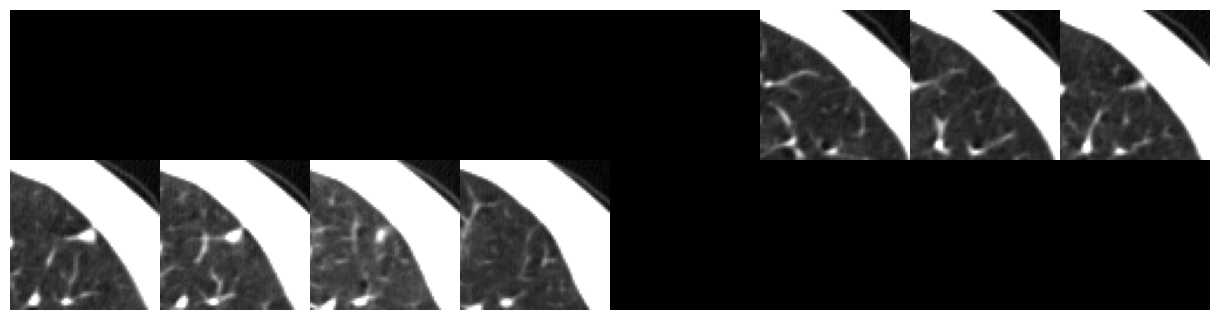

0 - 73.04%


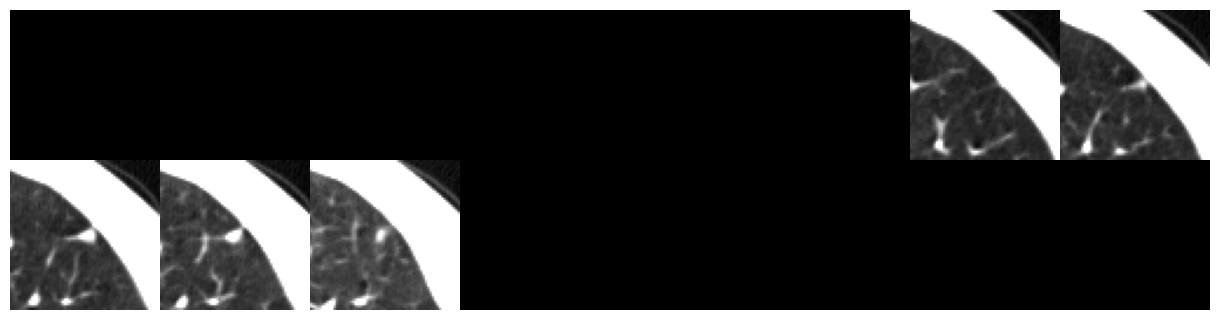

1 - 73.02%


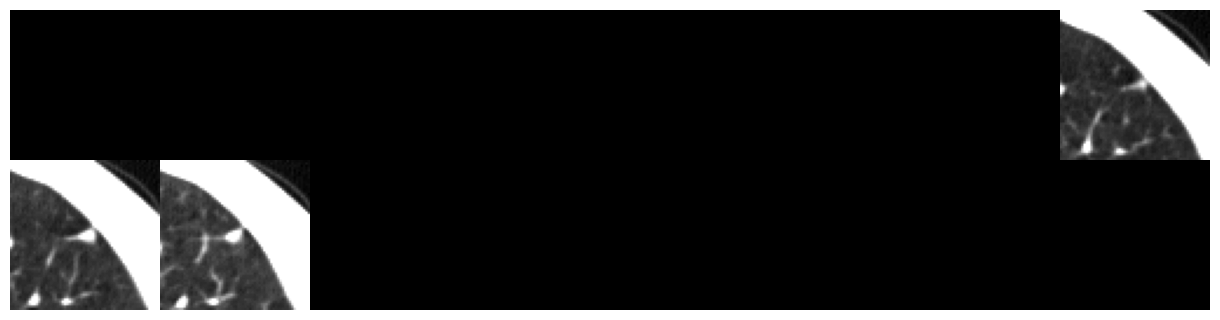

1 - 73.09%


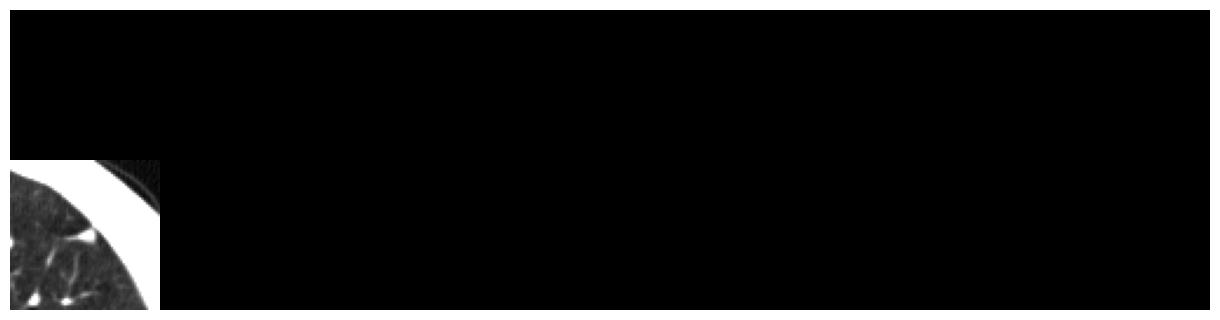

1 - 66.84%


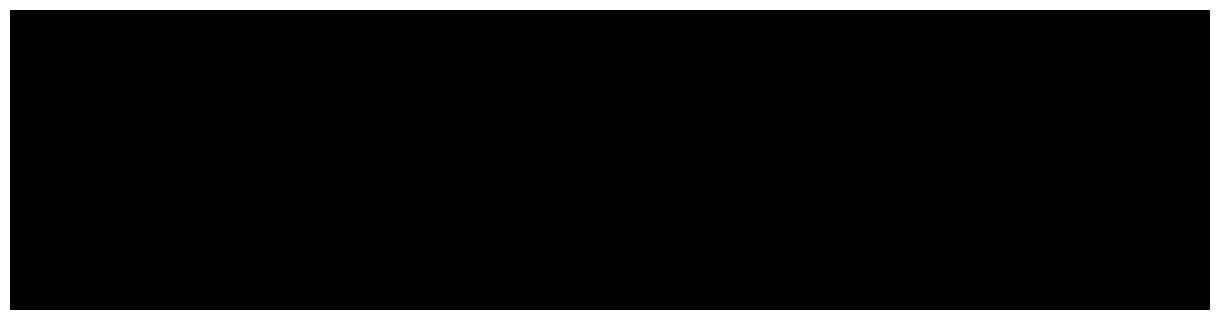

In [134]:
print(f'Ground truth: {img_label}')

for i in range(len(imgs)):  
  
    certainity = softmax_predictions[i].numpy().max()  
    label = np.argmax(softmax_predictions[i])  
    print(f"{label} - {certainity:.2%}")
    plot_slices(
    num_rows=2, 
    num_columns=8, 
    width=64, 
    height=64, 
    data=imgs[i].transpose()
)

The model has a constant confidence of 73% on it's prediction, even when it's incorrect. 

### 2 conclusions:

1) It looks like our model is overconfident in its predictions.

2) It looks like the model does a bad job at computing the prediction uncertainity.

# Adding MC dropout to our model

Let’s see what a slightly different model would predict on these images. We’ll now use MC dropout as our model. By sampling, we should be able to increase the models’ uncertainty compared to a standard NN. 

Let’s first define our model:

In [65]:
def get_dropout_model():    
    model = keras.Sequential()
    model.add(layers.Convolution3D(filters=8, kernel_size=(5, 5, 5), strides=1, activation='relu', input_shape=(16,64,64,1)))
    model.add(layers.Dropout(0.2))
    model.add(layers.MaxPooling3D(pool_size=(2, 2,2), strides=2))
    model.add(layers.Convolution3D(filters=16, kernel_size=(5, 5, 5),strides=1, activation='relu'))
    model.add(layers.MaxPooling3D(pool_size=(2, 2,2), strides=2))
    model.add(layers.Dropout(0.5))
    model.add(layers.Flatten())
    model.add(layers.Dense(units=150, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(units=100, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(units=50, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(units=2, activation = 'softmax'))
    
    return model

def le_net_3d_dropout():
    model = keras.Sequential()
    model.add(layers.Convolution3D(6, kernel_size=(5, 5, 5), activation='relu', input_shape=(16,64,64,1)))
    
    model.add(layers.Dropout(0.2))
    model.add(layers.MaxPooling3D(strides=2)) 
    model.add(layers.Convolution3D(16, kernel_size=(5, 5, 5), activation='relu'))
    model.add(layers.MaxPooling3D(strides=2))
    
    model.add(layers.Dropout(0.5))
    model.add(layers.Flatten())
    model.add(layers.Dense(120, activation='relu'))
    
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(84, activation='relu'))
    
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(2, activation='softmax'))

    return model

Then let’s instantiate it:

In [66]:
dropout_model = le_net_3d_dropout()  
dropout_model = fit_model(dropout_model, epochs=50)

Epoch 1/50
67/67 [==============================] - 20s 269ms/step - loss: 0.6895 - accuracy: 0.5261 - val_loss: 0.6761 - val_accuracy: 0.5903
Epoch 2/50
67/67 [==============================] - 17s 250ms/step - loss: 0.6854 - accuracy: 0.5553 - val_loss: 0.6718 - val_accuracy: 0.6094
Epoch 3/50
67/67 [==============================] - 18s 269ms/step - loss: 0.6789 - accuracy: 0.5765 - val_loss: 0.6594 - val_accuracy: 0.6266
Epoch 4/50
67/67 [==============================] - 18s 264ms/step - loss: 0.6793 - accuracy: 0.5770 - val_loss: 0.6833 - val_accuracy: 0.5903
Epoch 5/50
67/67 [==============================] - 18s 264ms/step - loss: 0.6798 - accuracy: 0.5709 - val_loss: 0.6910 - val_accuracy: 0.5778
Epoch 6/50
67/67 [==============================] - 18s 266ms/step - loss: 0.6825 - accuracy: 0.5775 - val_loss: 0.6752 - val_accuracy: 0.6094
Epoch 7/50
67/67 [==============================] - 18s 263ms/step - loss: 0.6811 - accuracy: 0.5850 - val_loss: 0.6780 - val_accuracy: 0.5979

Our model with dropout will achieve a similar accuracy as our vanilla model. Let’s now run inference with dropout and plot the mean confidence score of MC dropout:

In [135]:
predictions = np.array(  
    [  
        tf.nn.softmax(dropout_model(np.expand_dims(imgs, -1), training=True), axis=1)  
        for _ in range(100)  
    ]  
)  
predictions_mean = np.mean(predictions, axis=0)  

This again produces a figure showing the predicted labels and their associated confidence scores:

In [136]:
def plot_predictions(predictions, imgs):
    for i in range(len(imgs)):
        certainity = predictions[i].max()  
        label = np.argmax(predictions[i])  
        print(f"{label} - {certainity:.2%}")
        plot_slices(
        num_rows=2, 
        num_columns=8, 
        width=64, 
        height=64, 
        data=imgs[i].transpose()
)

Ground truth: 0
1 - 61.65%


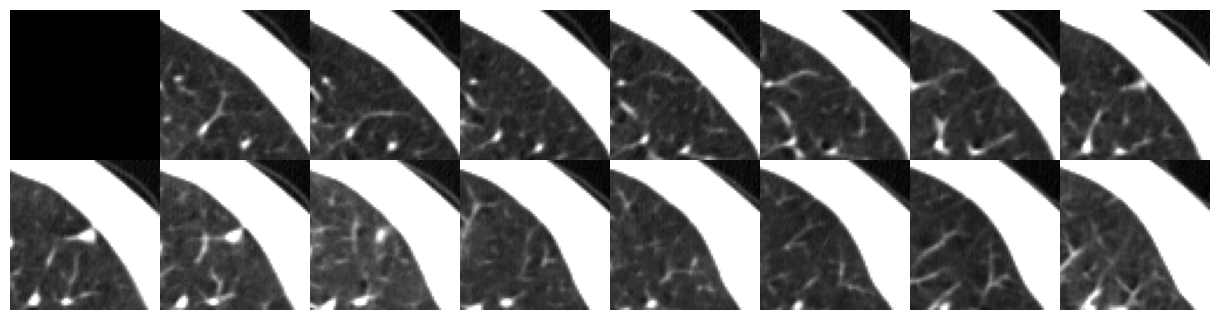

1 - 56.46%


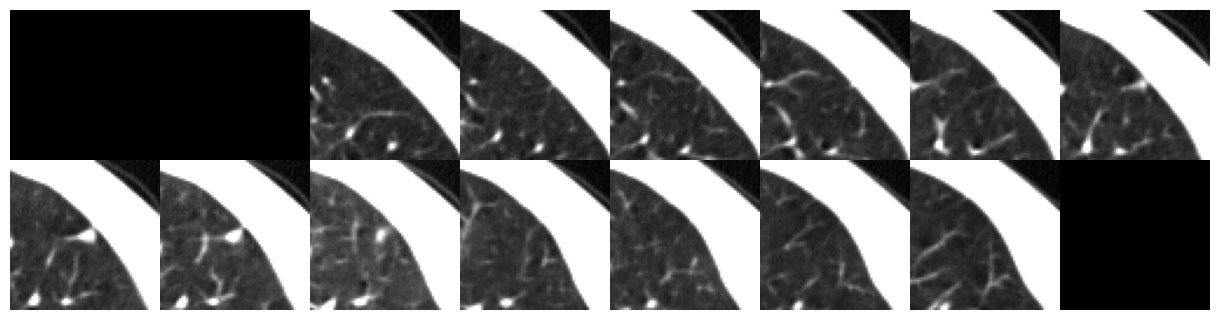

1 - 62.59%


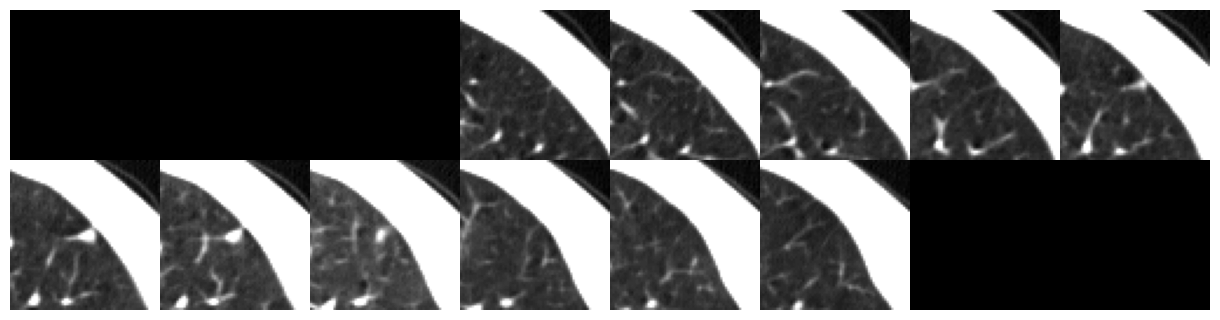

1 - 55.25%


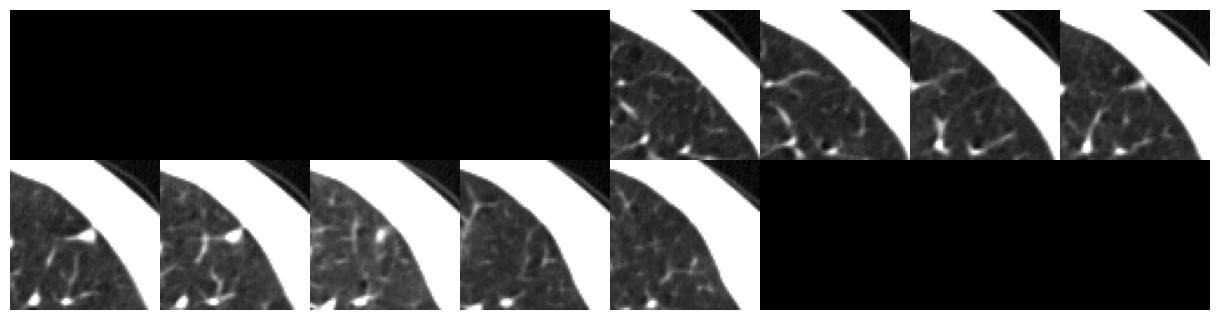

1 - 54.82%


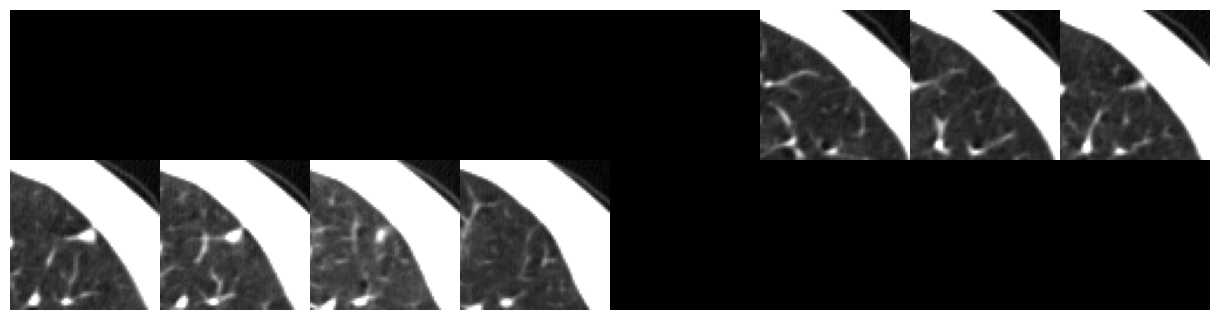

0 - 62.49%


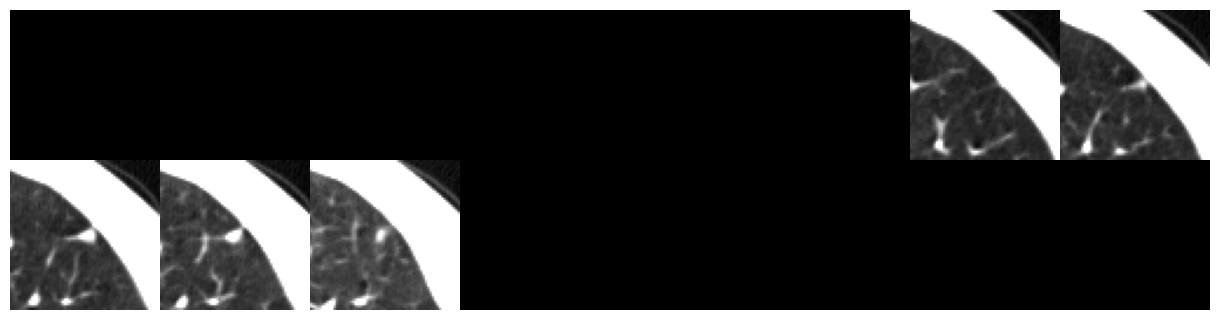

0 - 54.70%


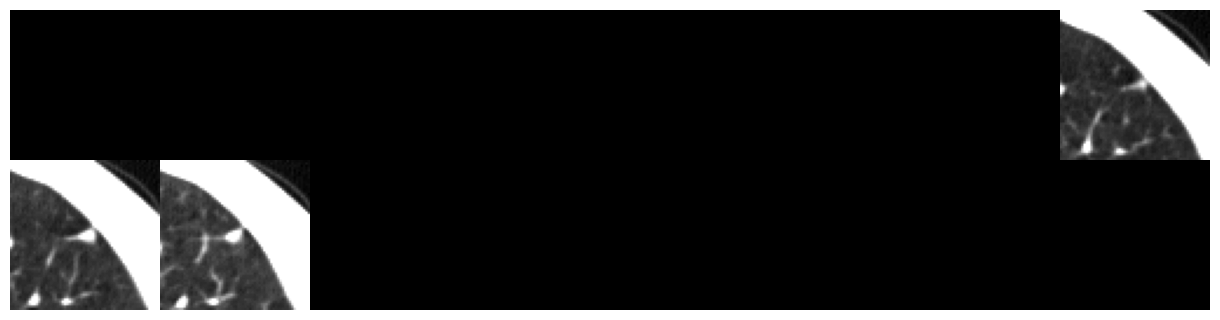

0 - 58.83%


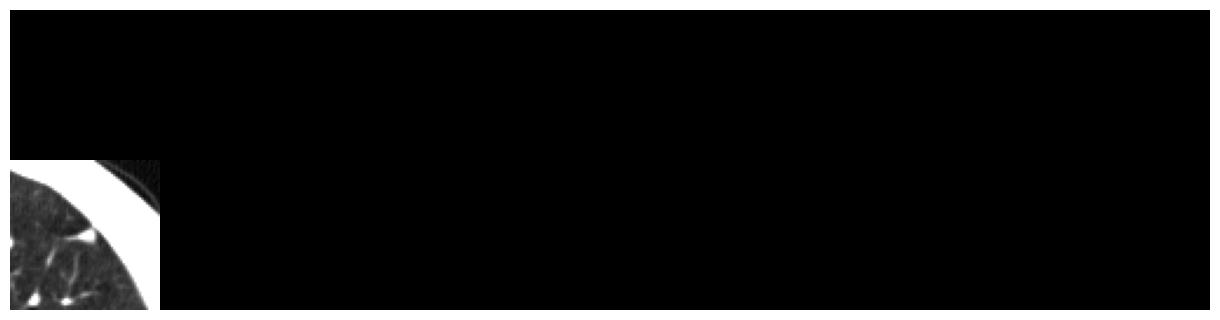

1 - 57.09%


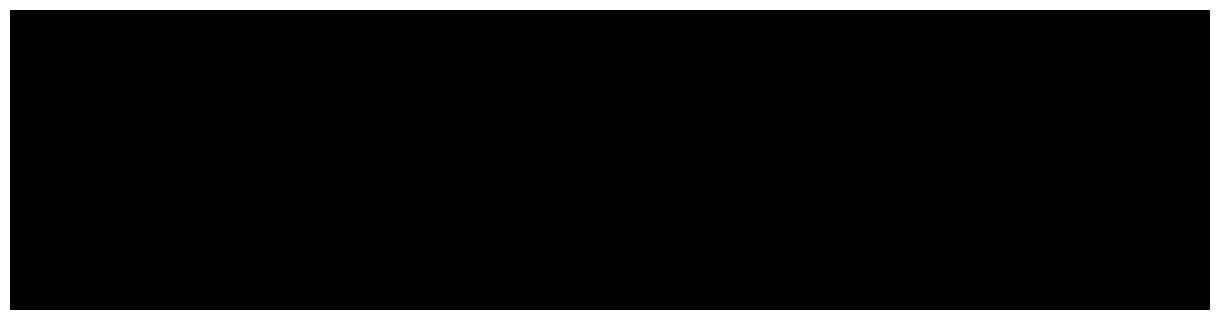

In [137]:
print(f'Ground truth: {img_label}')
plot_predictions(predictions_mean, imgs)

### 3 conclusions:

The highest confidence belongs to a correct prediction

The model can interpret better the data when less than half of the slices are used

The model has a slight tendency to clasify black images as malign

# Next step
Reduce the number of slices